In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
import time
from tqdm import tqdm
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Phase 0: Baseline Setup

### Data Loading (Cifar-100)

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

trainset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(
    root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

100%|██████████| 169M/169M [00:01<00:00, 102MB/s]  


### Model Definition (VGG-11)

In [3]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 100),
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AdaptiveAvgPool2d((1, 1))]
        return nn.Sequential(*layers)

In [4]:
def train_model(model, trainloader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(trainloader, desc=f"Epoch {epoch+1} [Train]")
    
    for batch_idx, (inputs, targets) in enumerate(progress_bar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar.set_postfix(loss=running_loss/(batch_idx+1), acc=100.*correct/total)

def test_model(model, testloader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(testloader, desc=f"Epoch {epoch+1} [Test]")
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(progress_bar):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar.set_postfix(loss=test_loss/(batch_idx+1), acc=100.*correct/total)

    acc = 100. * correct / total
    return acc

### Training the Baseline Model

In [7]:
model = VGG('VGG11').to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

NUM_EPOCHS = 200
best_acc = 0.0
MODEL_PATH = 'original_model.pth'

for epoch in range(NUM_EPOCHS):
    train_model(model, trainloader, optimizer, criterion, epoch)
    acc = test_model(model, testloader, criterion, epoch)
    
    if acc > best_acc:
        print(f"New best accuracy: {acc:.2f}%. Saving model...")
        torch.save(model.state_dict(), MODEL_PATH)
        best_acc = acc
        
    scheduler.step()

print(f"Finished Training. Best Test Accuracy: {best_acc:.2f}%")
print(f"Baseline model saved to {MODEL_PATH}")

Epoch 1 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.41it/s, acc=6.28, loss=4.07]


New best accuracy: 6.28%. Saving model...


Epoch 2 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.62it/s, acc=7.24, loss=4]  


New best accuracy: 7.24%. Saving model...


Epoch 3 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.85it/s, acc=11.2, loss=3.71]


New best accuracy: 11.15%. Saving model...


Epoch 4 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.38it/s, acc=16, loss=3.44] 


New best accuracy: 16.04%. Saving model...


Epoch 5 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.28it/s, acc=18.5, loss=3.48]


New best accuracy: 18.46%. Saving model...


Epoch 6 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.93it/s, acc=25.4, loss=2.91]


New best accuracy: 25.40%. Saving model...


Epoch 7 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.53it/s, acc=29.5, loss=2.81]


New best accuracy: 29.46%. Saving model...


Epoch 9 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.73it/s, acc=30.6, loss=2.74]


New best accuracy: 30.55%. Saving model...


Epoch 10 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.32it/s, acc=33.6, loss=2.58]


New best accuracy: 33.58%. Saving model...


Epoch 11 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.16it/s, acc=37.4, loss=2.46]


New best accuracy: 37.37%. Saving model...


Epoch 13 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.16it/s, acc=38.8, loss=2.46]


New best accuracy: 38.78%. Saving model...


Epoch 14 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.27it/s, acc=43, loss=2.19] 


New best accuracy: 43.04%. Saving model...


Epoch 19 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.41it/s, acc=43.3, loss=2.21]


New best accuracy: 43.27%. Saving model...


Epoch 23 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.63it/s, acc=46.9, loss=2.07]


New best accuracy: 46.94%. Saving model...


Epoch 27 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.41it/s, acc=50, loss=1.91] 


New best accuracy: 50.04%. Saving model...


Epoch 46 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.19it/s, acc=50.5, loss=1.98]


New best accuracy: 50.46%. Saving model...


Epoch 47 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.87it/s, acc=52.6, loss=1.86]


New best accuracy: 52.57%. Saving model...


Epoch 49 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.83it/s, acc=53.2, loss=1.81]


New best accuracy: 53.17%. Saving model...


Epoch 55 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.60it/s, acc=53.6, loss=1.8]


New best accuracy: 53.65%. Saving model...


Epoch 69 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.05it/s, acc=54, loss=1.76] 


New best accuracy: 53.99%. Saving model...


Epoch 75 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.22it/s, acc=54, loss=1.84] 


New best accuracy: 54.02%. Saving model...


Epoch 79 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.06it/s, acc=57.3, loss=1.67]


New best accuracy: 57.26%. Saving model...


Epoch 90 [Test]: 100%|██████████| 100/100 [00:01<00:00, 57.16it/s, acc=57.5, loss=1.69]


New best accuracy: 57.46%. Saving model...


Epoch 95 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.04it/s, acc=59.1, loss=1.61]


New best accuracy: 59.11%. Saving model...


Epoch 96 [Test]: 100%|██████████| 100/100 [00:01<00:00, 59.26it/s, acc=59.1, loss=1.61]


New best accuracy: 59.12%. Saving model...


Epoch 98 [Test]: 100%|██████████| 100/100 [00:01<00:00, 57.32it/s, acc=59.9, loss=1.6]


New best accuracy: 59.86%. Saving model...


Epoch 110 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.15it/s, acc=60.3, loss=1.57]


New best accuracy: 60.34%. Saving model...


Epoch 114 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.60it/s, acc=60.6, loss=1.57]


New best accuracy: 60.58%. Saving model...


Epoch 121 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.35it/s, acc=60.7, loss=1.63]


New best accuracy: 60.67%. Saving model...


Epoch 124 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.35it/s, acc=61.3, loss=1.63]


New best accuracy: 61.26%. Saving model...


Epoch 126 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.85it/s, acc=61.4, loss=1.64]


New best accuracy: 61.35%. Saving model...


Epoch 130 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.65it/s, acc=62.1, loss=1.66]


New best accuracy: 62.08%. Saving model...


Epoch 131 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.92it/s, acc=62.4, loss=1.61]


New best accuracy: 62.44%. Saving model...


Epoch 133 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.06it/s, acc=63, loss=1.57] 


New best accuracy: 62.96%. Saving model...


Epoch 136 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.81it/s, acc=63.4, loss=1.59]


New best accuracy: 63.42%. Saving model...


Epoch 138 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.71it/s, acc=63.6, loss=1.59]


New best accuracy: 63.64%. Saving model...


Epoch 139 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.57it/s, acc=64.2, loss=1.59]


New best accuracy: 64.16%. Saving model...


Epoch 144 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.44it/s, acc=65.4, loss=1.57]


New best accuracy: 65.36%. Saving model...


Epoch 152 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.67it/s, acc=66.6, loss=1.63]


New best accuracy: 66.58%. Saving model...


Epoch 160 [Test]: 100%|██████████| 100/100 [00:01<00:00, 57.07it/s, acc=67.3, loss=1.62]


New best accuracy: 67.32%. Saving model...


Epoch 161 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.05it/s, acc=67.4, loss=1.62]


New best accuracy: 67.36%. Saving model...


Epoch 162 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.00it/s, acc=67.6, loss=1.6]


New best accuracy: 67.58%. Saving model...


Epoch 163 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.61it/s, acc=67.9, loss=1.57]


New best accuracy: 67.92%. Saving model...


Epoch 164 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.55it/s, acc=68.5, loss=1.57]


New best accuracy: 68.48%. Saving model...


Epoch 165 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.15it/s, acc=68.7, loss=1.54]


New best accuracy: 68.72%. Saving model...


Epoch 167 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.71it/s, acc=69, loss=1.53] 


New best accuracy: 69.03%. Saving model...


Epoch 168 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.96it/s, acc=69.3, loss=1.53]


New best accuracy: 69.30%. Saving model...


Epoch 169 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.94it/s, acc=69.8, loss=1.48]


New best accuracy: 69.83%. Saving model...


Epoch 171 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.12it/s, acc=70, loss=1.47] 


New best accuracy: 69.96%. Saving model...


Epoch 172 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.44it/s, acc=70.2, loss=1.46]


New best accuracy: 70.23%. Saving model...


Epoch 173 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.67it/s, acc=70.3, loss=1.44]


New best accuracy: 70.32%. Saving model...


Epoch 174 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.09it/s, acc=70.5, loss=1.41]


New best accuracy: 70.55%. Saving model...


Epoch 175 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.87it/s, acc=70.8, loss=1.4]


New best accuracy: 70.79%. Saving model...


Epoch 176 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.01it/s, acc=71, loss=1.39] 


New best accuracy: 70.97%. Saving model...


Epoch 177 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.17it/s, acc=71.1, loss=1.38]


New best accuracy: 71.06%. Saving model...


Epoch 179 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.84it/s, acc=71.2, loss=1.37]


New best accuracy: 71.16%. Saving model...


Epoch 182 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.19it/s, acc=71.4, loss=1.35]


New best accuracy: 71.41%. Saving model...


Epoch 184 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.98it/s, acc=71.5, loss=1.33]


New best accuracy: 71.46%. Saving model...


Epoch 189 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.39it/s, acc=71.5, loss=1.32]


New best accuracy: 71.54%. Saving model...


Epoch 199 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.59it/s, acc=71.6, loss=1.32]


New best accuracy: 71.56%. Saving model...


Epoch 200 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.78it/s, acc=71.4, loss=1.32]

Finished Training. Best Test Accuracy: 71.56%
Baseline model saved to original_model.pth


In [8]:
def get_model_size(model_path):
    size_bytes = os.path.getsize(model_path)
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

def get_inference_time(model, testloader, device):
    model.eval()
    model.to(device)
    
    dummy_input = torch.randn(1, 3, 32, 32).to(device)
    
    starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
    
    num_runs = 500
    timings = torch.zeros((num_runs))

    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)

        for i in range(num_runs):
            starter.record()
            _ = model(dummy_input)
            ender.record()
            
            torch.cuda.synchronize()
            curr_time = starter.elapsed_time(ender)
            timings[i] = curr_time

    mean_time_ms = timings.mean().item()
    std_time_ms = timings.std().item()
    return mean_time_ms, std_time_ms

baseline_model = VGG('VGG11')
baseline_model.load_state_dict(torch.load(MODEL_PATH))
baseline_model.to(device)

print("--- Baseline Model Metrics ---")

baseline_size_mb = get_model_size(MODEL_PATH)
print(f"Model Size: {baseline_size_mb:.2f} MB")

baseline_acc = test_model(baseline_model, testloader, criterion, -1)
print(f"Test Accuracy: {baseline_acc:.2f}%")

if device.type == 'cuda':
    mean_ms, std_ms = get_inference_time(baseline_model, testloader, device)
    print(f"Avg. Inference Time (GPU): {mean_ms:.4f} ms (std: {std_ms:.4f})")
else:
    print("Inference time measurement is set up for GPU (CUDA). Skipping for CPU.")

print("--------------------------------")

--- Baseline Model Metrics ---
Model Size: 108.83 MB


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.74it/s, acc=71.6, loss=1.32]


Test Accuracy: 71.56%
Avg. Inference Time (GPU): 1.8051 ms (std: 0.0644)
--------------------------------


## Unstructured Pruning

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Helper function to plot weight distributions
def plot_weight_distribution(model, title="Weight Distribution"):
    weights = []
    for param in model.parameters():
        if param.dim() > 1:  # Only look at weight matrices, not biases
            weights.extend(param.data.cpu().numpy().flatten())
    
    plt.figure(figsize=(10, 6))
    plt.hist(weights, bins=100, alpha=0.7, log=True)
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency (Log Scale)")
    plt.show()

# Helper function to apply a pruning mask
def apply_pruning_mask(layer, mask):
    # We use torch.no_grad() to modify the weights in-place
    # without tracking it in autograd
    with torch.no_grad():
        layer.weight.data.mul_(mask)

In [10]:
def create_unstructured_mask(layer, sparsity_ratio):
    # Get the weight tensor
    weights = layer.weight.data
    
    # Calculate the L2-norm (magnitude) of each individual weight
    # For unstructured, this is just the absolute value
    abs_weights = torch.abs(weights)
    
    # Determine the threshold for pruning
    num_weights = weights.numel()
    num_to_prune = int(num_weights * sparsity_ratio)
    
    # Find the threshold value
    threshold = torch.kthvalue(abs_weights.view(-1), num_to_prune).values
    
    # Create the mask: 1 for weights > threshold, 0 for weights <= threshold
    mask = (abs_weights > threshold).float()
    
    return mask

In [11]:
def perform_sensitivity_analysis(model_path, testloader, device):
    print("Starting sensitivity analysis...")
    
    # Define the sparsity levels to test
    sparsity_ratios = [0.2, 0.4, 0.6, 0.8]
    
    # Store results in a dictionary: {layer_name: [acc_at_20, acc_at_40, ...]}
    results = {}
    
    # Get a list of all nn.Conv2d layers in the 'features' part of VGG-11
    model = VGG('VGG11')
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    
    layer_names = []
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            layer_names.append(name)
            
    print(f"Found {len(layer_names)} Conv2d layers: {layer_names}")

    criterion = nn.CrossEntropyLoss()
    
    for layer_name in layer_names:
        print(f"--- Analyzing Layer: {layer_name} ---")
        layer_accuracies = []
        
        for ratio in sparsity_ratios:
            # 1. Create a deep copy of the original model for a clean slate
            temp_model = VGG('VGG11')
            temp_model.load_state_dict(torch.load(model_path))
            temp_model.to(device)
            temp_model.eval()

            # 2. Find the specific layer in the copied model
            layer_to_prune = dict(temp_model.features.named_modules())[layer_name]
            
            # 3. Create and apply the mask
            mask = create_unstructured_mask(layer_to_prune, ratio)
            apply_pruning_mask(layer_to_prune, mask)
            
            # 4. Test the pruned model's accuracy
            # We pass epoch = -1 to test_model to suppress the epoch number
            acc = test_model(temp_model, testloader, criterion, epoch=-1)
            print(f"Sparsity: {ratio*100:.0f}%, Test Accuracy: {acc:.2f}%")
            layer_accuracies.append(acc)
            
            # Clean up memory
            del temp_model
            torch.cuda.empty_cache()
            
        results[layer_name] = layer_accuracies
        
    print("--- Sensitivity Analysis Complete ---")
    return results, layer_names

# --- Run the experiment ---
# This will take a while.
sensitivity_results, layer_names = perform_sensitivity_analysis(MODEL_PATH, testloader, device)

print("\n--- Final Results ---")
print(sensitivity_results)

Starting sensitivity analysis...
Found 8 Conv2d layers: ['0', '4', '8', '11', '15', '18', '22', '25']
--- Analyzing Layer: 0 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.91it/s, acc=71.6, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.57%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.93it/s, acc=70.9, loss=1.35]


Sparsity: 40%, Test Accuracy: 70.92%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 49.02it/s, acc=65.5, loss=1.6]


Sparsity: 60%, Test Accuracy: 65.49%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.77it/s, acc=27.1, loss=4.11]


Sparsity: 80%, Test Accuracy: 27.06%
--- Analyzing Layer: 4 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.26it/s, acc=71.6, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.60%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.08it/s, acc=71.7, loss=1.32]


Sparsity: 40%, Test Accuracy: 71.67%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.85it/s, acc=70.8, loss=1.35]


Sparsity: 60%, Test Accuracy: 70.85%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.12it/s, acc=63.9, loss=1.74]


Sparsity: 80%, Test Accuracy: 63.87%
--- Analyzing Layer: 8 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.01it/s, acc=71.5, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.45%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.03it/s, acc=71.3, loss=1.33]


Sparsity: 40%, Test Accuracy: 71.28%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.09it/s, acc=70, loss=1.37] 


Sparsity: 60%, Test Accuracy: 69.95%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.60it/s, acc=58.9, loss=1.95]


Sparsity: 80%, Test Accuracy: 58.92%
--- Analyzing Layer: 11 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.58it/s, acc=71.6, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.62%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.56it/s, acc=71.4, loss=1.33]


Sparsity: 40%, Test Accuracy: 71.42%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.01it/s, acc=69.2, loss=1.43]


Sparsity: 60%, Test Accuracy: 69.23%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.35it/s, acc=51, loss=2.56] 


Sparsity: 80%, Test Accuracy: 50.95%
--- Analyzing Layer: 15 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.55it/s, acc=71.5, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.55%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.92it/s, acc=71.4, loss=1.32]


Sparsity: 40%, Test Accuracy: 71.40%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.56it/s, acc=70.4, loss=1.35]


Sparsity: 60%, Test Accuracy: 70.43%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.56it/s, acc=63.2, loss=1.67]


Sparsity: 80%, Test Accuracy: 63.23%
--- Analyzing Layer: 18 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.03it/s, acc=71.6, loss=1.31]


Sparsity: 20%, Test Accuracy: 71.57%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 54.96it/s, acc=71.4, loss=1.3]


Sparsity: 40%, Test Accuracy: 71.40%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 55.95it/s, acc=70.2, loss=1.28]


Sparsity: 60%, Test Accuracy: 70.17%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 56.43it/s, acc=60.9, loss=1.76]


Sparsity: 80%, Test Accuracy: 60.88%
--- Analyzing Layer: 22 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.78it/s, acc=71.7, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.65%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 51.94it/s, acc=71.8, loss=1.33]


Sparsity: 40%, Test Accuracy: 71.77%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.36it/s, acc=71.7, loss=1.36]


Sparsity: 60%, Test Accuracy: 71.74%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 52.22it/s, acc=70.6, loss=1.43]


Sparsity: 80%, Test Accuracy: 70.61%
--- Analyzing Layer: 25 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 58.43it/s, acc=71.6, loss=1.32]


Sparsity: 20%, Test Accuracy: 71.57%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 50.57it/s, acc=71.5, loss=1.32]


Sparsity: 40%, Test Accuracy: 71.53%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 58.82it/s, acc=71.3, loss=1.32]


Sparsity: 60%, Test Accuracy: 71.35%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:01<00:00, 53.98it/s, acc=70.9, loss=1.3]

Sparsity: 80%, Test Accuracy: 70.88%
--- Sensitivity Analysis Complete ---

--- Final Results ---
{'0': [71.57, 70.92, 65.49, 27.06], '4': [71.6, 71.67, 70.85, 63.87], '8': [71.45, 71.28, 69.95, 58.92], '11': [71.62, 71.42, 69.23, 50.95], '15': [71.55, 71.4, 70.43, 63.23], '18': [71.57, 71.4, 70.17, 60.88], '22': [71.65, 71.77, 71.74, 70.61], '25': [71.57, 71.53, 71.35, 70.88]}


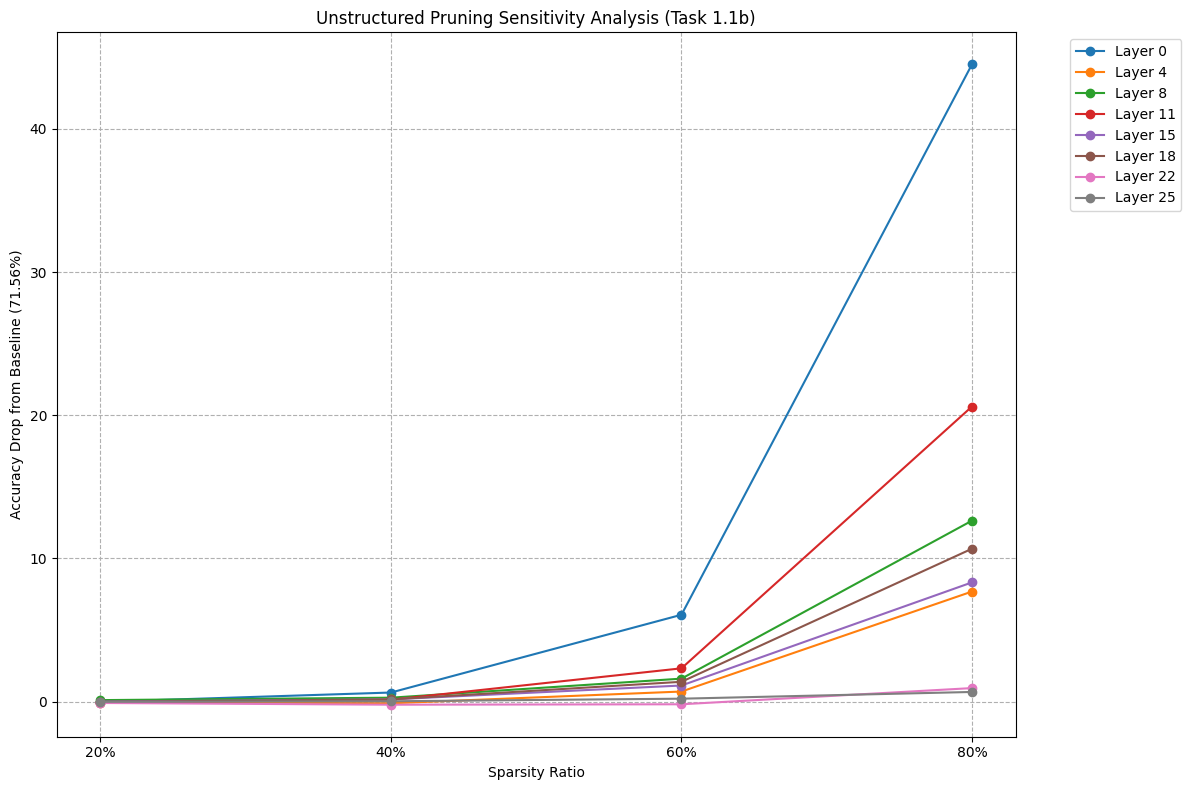

In [12]:
def plot_sensitivity_analysis(results, layer_names, baseline_acc):
    sparsity_ratios = [0.2, 0.4, 0.6, 0.8]
    
    plt.figure(figsize=(12, 8))
    
    for layer_name in layer_names:
        accuracies = results[layer_name]
        # We plot the 'Accuracy Drop'
        accuracy_drops = [baseline_acc - acc for acc in accuracies]
        plt.plot(sparsity_ratios, accuracy_drops, marker='o', label=f'Layer {layer_name}')
        
    plt.title('Unstructured Pruning Sensitivity Analysis (Task 1.1b)')
    plt.xlabel('Sparsity Ratio')
    plt.ylabel('Accuracy Drop from Baseline (71.56%)')
    plt.xticks(sparsity_ratios, [f'{r*100:.0f}%' for r in sparsity_ratios])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--')
    plt.tight_layout()
    plt.show()

# --- Run the plotting code ---
# Use the 'baseline_acc' variable (71.56) from your baseline run
baseline_acc = 71.56 
plot_sensitivity_analysis(sensitivity_results, layer_names, baseline_acc)

### Creating the 70% sparse model

In [30]:
# 1. LOAD BASELINE AND COUNT PARAMS

# Load the baseline model to count its parameters
model = VGG('VGG11')
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

# --- Find all prunable layers (Conv2d and Linear) ---
prunable_layers = {}
total_params = 0

print("--- Parameter Counts per Layer ---")
# Count parameters in Convolutional layers
for name, module in model.features.named_modules():
    if isinstance(module, nn.Conv2d):
        unique_name = f"features.{name}"
        num_params = module.weight.numel()
        prunable_layers[unique_name] = {'module': module, 'params': num_params}
        print(f"Layer {unique_name} (Conv2d): {num_params:,} parameters")
        total_params += num_params

# Count parameters in Linear (Classifier) layers
for name, module in model.classifier.named_modules():
    if isinstance(module, nn.Linear):
        unique_name = f"classifier.{name}"
        num_params = module.weight.numel()
        prunable_layers[unique_name] = {'module': module, 'params': num_params}
        print(f"Layer {unique_name} (Linear): {num_params:,} parameters")
        total_params += num_params

print("-----------------------------------")
print(f"Total Prunable Parameters: {total_params:,}")

--- Parameter Counts per Layer ---
Layer features.0 (Conv2d): 1,728 parameters
Layer features.4 (Conv2d): 73,728 parameters
Layer features.8 (Conv2d): 294,912 parameters
Layer features.11 (Conv2d): 589,824 parameters
Layer features.15 (Conv2d): 1,179,648 parameters
Layer features.18 (Conv2d): 2,359,296 parameters
Layer features.22 (Conv2d): 2,359,296 parameters
Layer features.25 (Conv2d): 2,359,296 parameters
Layer classifier.0 (Linear): 2,097,152 parameters
Layer classifier.3 (Linear): 16,777,216 parameters
Layer classifier.6 (Linear): 409,600 parameters
-----------------------------------
Total Prunable Parameters: 28,501,696


In [31]:
# 2. CALCULATE PRUNING SPARSITY RATIO

# --- Define Sparsity Targets ---
# Uses the unique names from the 'prunable_layers' dict
sparsity_targets = {
    'features.0': 0.10,      # Very light (Sensitive Conv)
    'features.4': 0.60,      # Moderate Conv
    'features.8': 0.60,      # Moderate Conv
    'features.11': 0.30,     # Light (Sensitive Conv)
    'features.15': 0.60,     # Moderate Conv
    'features.18': 0.60,     # Moderate Conv
    'features.22': 0.90,     # Aggressive (Insensitive Conv)
    'features.25': 0.90,     # Aggressive (Insensitive Conv)
    'classifier.0': 0.75,  # Aggressive (Large layer)
    'classifier.3': 0.69,  # Tuned to hit ~70%
    'classifier.6': 0.10,  # Very light (Final classifier)
}

# --- Calculate Overall Sparsity ---
total_params_calc = 0
total_pruned = 0
for name, data in prunable_layers.items():
    num_params = data['params']
    ratio = sparsity_targets[name]
    total_params_calc += num_params
    total_pruned += num_params * ratio

overall_sparsity = total_pruned / total_params_calc
print(f"Total parameters in calculation: {total_params_calc:,}")
print(f"Total parameters to be pruned: {int(total_pruned):,}")
print(f"Target Overall Sparsity: {overall_sparsity * 100:.2f}%")

Total parameters in calculation: 28,501,696
Total parameters to be pruned: 19,958,506
Target Overall Sparsity: 70.03%


In [32]:
# 3. CREATE, SAVE, AND TEST PRUNING MODEL

# --- Helper Functions ---
def create_unstructured_mask(layer, sparsity_ratio):
    weights = layer.weight.data
    abs_weights = torch.abs(weights)
    num_weights = weights.numel()
    num_to_prune = int(num_weights * sparsity_ratio)
    
    if num_to_prune == 0:
        return torch.ones_like(weights)
    
    threshold = torch.kthvalue(abs_weights.view(-1), num_to_prune).values
    mask = (abs_weights > threshold).float()
    return mask

def apply_pruning_mask(layer, mask):
    with torch.no_grad():
        layer.weight.data.mul_(mask)

# --- Load a fresh baseline model ---
pruned_model = VGG('VGG11')
pruned_model.load_state_dict(torch.load(MODEL_PATH))
pruned_model.to(device)
pruned_model.eval()

print("Applying masks to the new model object...")

# --- Prune Convolutional layers ---
for name, module in pruned_model.features.named_modules():
    if isinstance(module, nn.Conv2d):
        unique_name = f"features.{name}"
        if unique_name in sparsity_targets:
            ratio = sparsity_targets[unique_name]
            mask = create_unstructured_mask(module, ratio)
            apply_pruning_mask(module, mask)
            print(f"Applied {ratio*100:.0f}% sparsity to layer {unique_name}")

# --- Prune Linear layers ---
for name, module in pruned_model.classifier.named_modules():
    if isinstance(module, nn.Linear):
        unique_name = f"classifier.{name}"
        if unique_name in sparsity_targets:
            ratio = sparsity_targets[unique_name]
            mask = create_unstructured_mask(module, ratio)
            apply_pruning_mask(module, mask)
            print(f"Applied {ratio*100:.0f}% sparsity to layer {unique_name}")

# --- Save the pruned model ---
MODEL_PATH_UNSTRUCTURED = 'unstructured_pruned_70.pth'
torch.save(pruned_model.state_dict(), MODEL_PATH_UNSTRUCTURED)
print(f"Saved pruned model to {MODEL_PATH_UNSTRUCTURED}")

# --- Test the pruned model ---
print("Testing the pruned model...")
criterion = nn.CrossEntropyLoss()
baseline_acc = 71.56  # From our baseline run
final_acc = test_model(pruned_model, testloader, criterion, epoch=-1)

# --- Print the final analysis ---
print("-----------------------------------")
print(f"Baseline Accuracy: {baseline_acc:.2f}%")
print(f"Final 70% Pruned Accuracy: {final_acc:.2f}%")
print(f"Accuracy Drop: {baseline_acc - final_acc:.2f}%")
print("-----------------------------------")

Applying masks to the new model object...
Applied 10% sparsity to layer features.0
Applied 60% sparsity to layer features.4
Applied 60% sparsity to layer features.8
Applied 30% sparsity to layer features.11
Applied 60% sparsity to layer features.15
Applied 60% sparsity to layer features.18
Applied 90% sparsity to layer features.22
Applied 90% sparsity to layer features.25
Applied 75% sparsity to layer classifier.0
Applied 69% sparsity to layer classifier.3
Applied 10% sparsity to layer classifier.6
Saved pruned model to unstructured_pruned_70.pth
Testing the pruned model...


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 44.35it/s, acc=64.1, loss=1.63]

-----------------------------------
Baseline Accuracy: 71.56%
Final 70% Pruned Accuracy: 64.10%
Accuracy Drop: 7.46%
-----------------------------------


--- Plotting Final Distributions ---

--- Plotting 'Figure 1a: Original Model Weight Distribution' ---
  Total weights counted: 28,501,696
  Zero-value weights: 0 (0.00%)
  Non-zero weights: 28,501,696



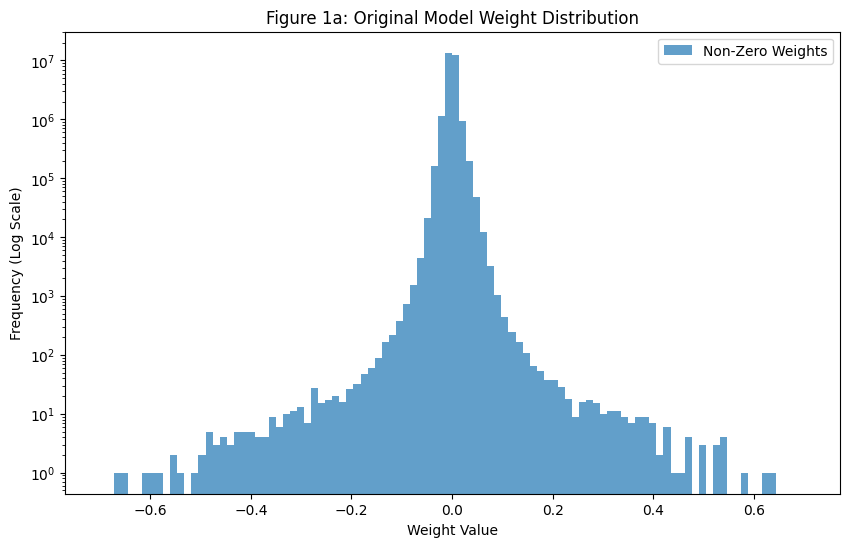


--- Plotting 'Figure 1b: Unstructured Pruned (70%) Model Weight Distribution' ---
  Total weights counted: 28,501,696
  Zero-value weights: 19,958,502 (70.03%)
  Non-zero weights: 8,543,194



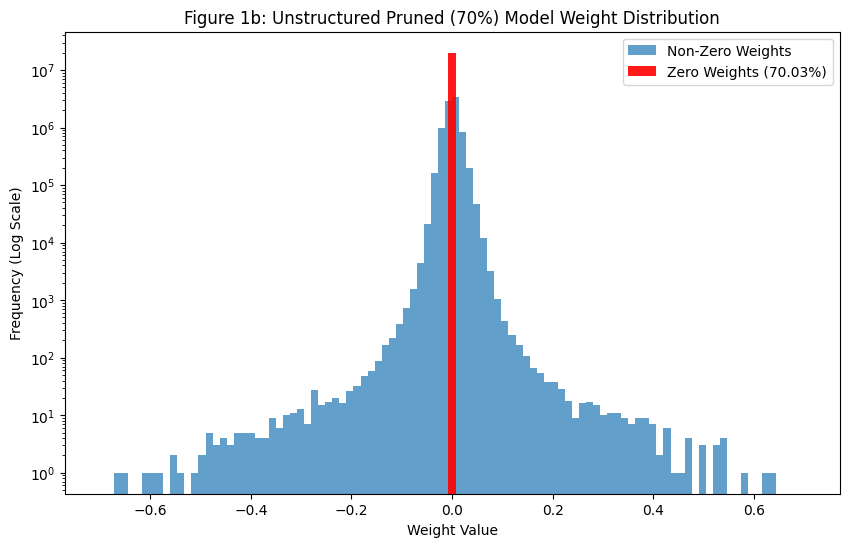

In [36]:
# 4. PLOT WEIGHT DISTRIBUTIONS (FINAL, VISUALLY CORRECT VERSION)

import numpy as np
import matplotlib.pyplot as plt

# --- Corrected Plotting Function ---
def plot_weight_distribution(model, title="Weight Distribution"):
    weights = []
    
    # Explicitly iterate through modules to gather all weights
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            weights.extend(module.weight.data.cpu().numpy().flatten())
    
    for name, module in model.classifier.named_modules():
        if isinstance(module, nn.Linear):
            weights.extend(module.weight.data.cpu().numpy().flatten())
    
    weights = np.array(weights)
    
    # --- Get stats ---
    non_zero_weights = weights[weights != 0]
    num_zeros = len(weights) - len(non_zero_weights)
    total_weights = len(weights)
    
    print(f"\n--- Plotting '{title}' ---")
    print(f"  Total weights counted: {total_weights:,}")
    print(f"  Zero-value weights: {num_zeros:,} ({num_zeros/total_weights*100:.2f}%)")
    print(f"  Non-zero weights: {len(non_zero_weights):,}\n")
    
    # --- Plot histogram ---
    plt.figure(figsize=(10, 6))
    plt.yscale('log') # Set log scale manually
    
    # 1. Plot the histogram of ONLY the non-zero weights
    #    This shows the shape of the surviving distribution
    plt.hist(non_zero_weights, bins=100, alpha=0.7, range=(-0.7, 0.7), label='Non-Zero Weights') 
    
    # 2. Manually add a bar for the zero-value weights
    if num_zeros > 0:
        # We plot this on the log scale
        # The bar is centered at 0, with a small width
        plt.bar(0, num_zeros, width=0.015, color='red', alpha=0.9, label=f'Zero Weights ({num_zeros/total_weights*100:.2f}%)')
    
    plt.title(title)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency (Log Scale)")
    plt.legend()
    plt.show()

# --- Run the Plotting ---
print("--- Plotting Final Distributions ---")

# 1. Load and plot the baseline model
baseline_model = VGG('VGG11')
baseline_model.load_state_dict(torch.load(MODEL_PATH))
plot_weight_distribution(baseline_model, title="Figure 1a: Original Model Weight Distribution")

# 2. Load and plot the 70% pruned model
pruned_model = VGG('VGG11')
pruned_model.load_state_dict(torch.load('unstructured_pruned_70.pth'))
plot_weight_distribution(pruned_model, title="Figure 1b: Unstructured Pruned (70%) Model Weight Distribution")

In [41]:
# 1. Define the path to our new model
MODEL_PATH_UNSTRUCTURED = 'unstructured_pruned_70.pth'

# 2. Get File Size
pruned_size_mb = get_model_size(MODEL_PATH_UNSTRUCTURED)

# 3. Load the pruned model to test its speed
pruned_model_for_speed_test = VGG('VGG11')
pruned_model_for_speed_test.load_state_dict(torch.load(MODEL_PATH_UNSTRUCTURED))
pruned_model_for_speed_test.to(device)
pruned_model_for_speed_test.eval()

# 4. Get Inference Time
pruned_mean_ms, pruned_std_ms = get_inference_time(pruned_model_for_speed_test, testloader, device)

# --- Print Comparison ---
print("\n--- Model Comparison (Storage & Speed) ---")
print(f"                                | Baseline      | Unstructured (70%)")
print(f"--------------------------------|---------------|-------------------")
print(f"File Size (MB)                  | {baseline_size_mb:<13.2f} | {pruned_size_mb:<18.2f}")
print(f"Avg. Inference Time (ms)        | {1.8051}        | {pruned_mean_ms:<18.4f}")

del pruned_model_for_speed_test # Clean up memory


--- Model Comparison (Storage & Speed) ---
                                | Baseline      | Unstructured (70%)
--------------------------------|---------------|-------------------
File Size (MB)                  | 108.83        | 108.83            
Avg. Inference Time (ms)        | 1.8051        | 1.7854            


In [47]:
def create_globally_pruned_model(model_path, global_sparsity_ratio):
    """
    Creates a new model pruned to a global sparsity ratio.
    """
    # 1. Load a fresh baseline model
    model = VGG('VGG11')
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    # 2. Gather all weights from all prunable layers into one big tensor
    all_weights = []
    for name, module in model.features.named_modules():
        if isinstance(module, nn.Conv2d):
            all_weights.append(module.weight.data.view(-1)) # Corrected
    
    for name, module in model.classifier.named_modules():
        if isinstance(module, nn.Linear):
            all_weights.append(module.weight.data.view(-1)) # Corrected
            
    all_weights_tensor = torch.cat(all_weights)
    
    # 3. Find the global threshold
    num_to_prune = int(all_weights_tensor.numel() * global_sparsity_ratio)
    
    # Handle the k=0 case
    if num_to_prune == 0:
        print("Sparsity is 0%, returning original model.")
        return model
    
    # Handle the k=num_elements case (100% sparsity)
    if num_to_prune >= all_weights_tensor.numel():
        threshold = torch.max(torch.abs(all_weights_tensor)) + 1.0
    else:
        # k must be at least 1
        threshold = torch.kthvalue(torch.abs(all_weights_tensor), max(1, num_to_prune)).values
    
    # 4. Apply this global threshold to all layers
    with torch.no_grad():
        for name, module in model.features.named_modules():
            if isinstance(module, nn.Conv2d):
                mask = (torch.abs(module.weight.data) > threshold).float()
                module.weight.data.mul_(mask)
        
        for name, module in model.classifier.named_modules():
            if isinstance(module, nn.Linear):
                mask = (torch.abs(module.weight.data) > threshold).float()
                module.weight.data.mul_(mask)
                
    return model

In [48]:
# --- Main Experiment (Task 1.3d) ---
print("--- Starting Task 1.3d: Accuracy vs. Sparsity Plot (Corrected) ---")

sparsity_levels_to_run = [0.0, 0.2, 0.4, 0.6, 0.8]
accuracy_map = {} # Use a dictionary to store results
criterion = nn.CrossEntropyLoss()

for ratio in sparsity_levels_to_run:
    print(f"\n--- Testing Global Sparsity: {ratio*100:.0f}% ---")
    pruned_model = create_globally_pruned_model(MODEL_PATH, ratio)
    acc = test_model(pruned_model, testloader, criterion, epoch=-1)
    accuracy_map[ratio] = acc
    print(f"Accuracy at {ratio*100:.0f}%: {acc:.2f}%")
    del pruned_model # Clean up memory

print("--- Experiment Complete ---")

--- Starting Task 1.3d: Accuracy vs. Sparsity Plot (Corrected) ---

--- Testing Global Sparsity: 0% ---
Sparsity is 0%, returning original model.


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.53it/s, acc=71.6, loss=1.32]


Accuracy at 0%: 71.56%

--- Testing Global Sparsity: 20% ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.37it/s, acc=71.5, loss=1.32]


Accuracy at 20%: 71.55%

--- Testing Global Sparsity: 40% ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.37it/s, acc=71.6, loss=1.3]


Accuracy at 40%: 71.64%

--- Testing Global Sparsity: 60% ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.75it/s, acc=71.3, loss=1.21]


Accuracy at 60%: 71.28%

--- Testing Global Sparsity: 80% ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.43it/s, acc=68.4, loss=2.26]


Accuracy at 80%: 68.43%
--- Experiment Complete ---



Final Data Points for Plot:
  Sparsity: 0%, Accuracy: 71.56%
  Sparsity: 20%, Accuracy: 71.55%
  Sparsity: 40%, Accuracy: 71.64%
  Sparsity: 60%, Accuracy: 71.28%
  Sparsity: 80%, Accuracy: 68.43%


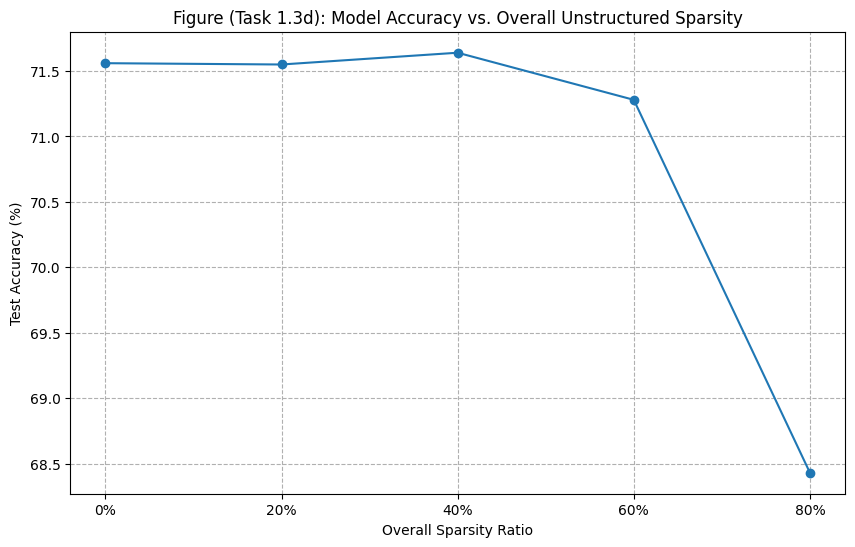

In [49]:
# --- Generate the Plot ---
plot_sparsity = sorted(accuracy_map.keys())
plot_accuracy = [accuracy_map[s] for s in plot_sparsity]

print(f"\nFinal Data Points for Plot:")
for s, a in zip(plot_sparsity, plot_accuracy):
    print(f"  Sparsity: {s*100:.0f}%, Accuracy: {a:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(plot_sparsity, plot_accuracy, marker='o', linestyle='-')
plt.title('Figure (Task 1.3d): Model Accuracy vs. Overall Unstructured Sparsity')
plt.xlabel('Overall Sparsity Ratio')
plt.ylabel('Test Accuracy (%)')
plt.xticks(plot_sparsity, [f'{s*100:.0f}%' for s in plot_sparsity])
plt.grid(True, linestyle='--')
plt.show()

## Structured Pruning

In [56]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import copy
from collections import OrderedDict
from tqdm import tqdm
import time
import os

# (Assuming VGG, test_model, device, MODEL_PATH, etc., are still in memory)

# --- Function 1: Get Channel Importance (from Lab1 Q7) ---
def get_input_channel_importance(weight):
    """
    Calculates the L2-norm of each input channel.
    Input weight shape: (out_channels, in_channels, k, k)
    """
    in_channels = weight.shape[1]
    importances = []
    # Compute the importance for each input channel
    for i_c in range(in_channels):
        channel_weight = weight.detach()[:, i_c]
        # Calculate L2-norm
        importance = torch.norm(channel_weight)
        importances.append(importance.view(1))
    return torch.cat(importances)

# --- Function 2: Apply Channel Sorting (from Lab1 Q7) ---
@torch.no_grad()
def apply_channel_sorting(model_to_sort):
    """
    Re-orders the model's channels based on magnitude, from most to least important.
    This does not change the model's accuracy.
    """
    model = copy.deepcopy(model_to_sort) # Do not modify the original
    
    all_convs = [m for m in model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in model.features if isinstance(m, nn.BatchNorm2d)]
    
    # Iterate through all conv layers *except the last one*
    for i_conv in range(len(all_convs) - 1):
        prev_conv = all_convs[i_conv]
        prev_bn = all_bns[i_conv]
        next_conv = all_convs[i_conv + 1]
        
        # Get importance from the *input* channels of the *next* conv layer
        importance = get_input_channel_importance(next_conv.weight)
        
        # Get the sorting index (descending)
        sort_idx = torch.argsort(importance, descending=True)
        
        # --- Apply this sorting index to all dependent layers ---
        # 1. Previous Conv (Output Channels)
        prev_conv.weight.copy_(torch.index_select(
            prev_conv.weight.detach(), 0, sort_idx.to(device)))
        if prev_conv.bias is not None:
            prev_conv.bias.copy_(torch.index_select(
                prev_conv.bias.detach(), 0, sort_idx.to(device)))

        # 2. Previous BN
        for tensor_name in ['weight', 'bias', 'running_mean', 'running_var']:
            tensor_to_apply = getattr(prev_bn, tensor_name)
            tensor_to_apply.copy_(
                torch.index_select(tensor_to_apply.detach(), 0, sort_idx.to(device))
            )

        # 3. Next Conv (Input Channels)
        next_conv.weight.copy_(torch.index_select(
            next_conv.weight.detach(), 1, sort_idx.to(device)))
            
    return model

# --- Function 3: Channel Pruning (from Lab1 Q6) ---
def get_num_channels_to_keep(channels: int, prune_ratio: float) -> int:
    """Calculates the number of channels to PRESERVE."""
    return int(round(channels * (1.0 - prune_ratio)))

@torch.no_grad()
def channel_prune(sorted_model: nn.Module, 
                  prune_ratio_list: list) -> nn.Module:
    """
    Applies "naive" channel pruning (chops off the last N channels)
    to a SORTED model, creating a new, smaller model.
    """
    # Create a new model to build the pruned architecture
    pruned_model = copy.deepcopy(sorted_model)
    
    all_convs = [m for m in pruned_model.features if isinstance(m, nn.Conv2d)]
    all_bns = [m for m in pruned_model.features if isinstance(m, nn.BatchNorm2d)]
    
    # We only prune the n-1 connections between conv layers
    for i_ratio, p_ratio in enumerate(prune_ratio_list):
        prev_conv = all_convs[i_ratio]
        prev_bn = all_bns[i_ratio]
        next_conv = all_convs[i_ratio + 1]
        
        original_channels = prev_conv.out_channels
        n_keep = get_num_channels_to_keep(original_channels, p_ratio)
        
        if n_keep == original_channels:
            continue # No pruning for this layer
            
        # --- Re-create the layers with new (smaller) dimensions ---
        
        # 1. Prune Previous Conv (Output)
        new_prev_conv = nn.Conv2d(
            in_channels=prev_conv.in_channels,
            out_channels=n_keep,
            kernel_size=prev_conv.kernel_size,
            stride=prev_conv.stride,
            padding=prev_conv.padding,
            bias=(prev_conv.bias is not None)
        ).to(device)
        # Copy the *kept* weights
        new_prev_conv.weight.data.copy_(prev_conv.weight.data[:n_keep])
        if prev_conv.bias is not None:
            new_prev_conv.bias.data.copy_(prev_conv.bias.data[:n_keep])
            
        # 2. Prune Previous BN
        new_prev_bn = nn.BatchNorm2d(
            num_features=n_keep
        ).to(device)
        # Copy the *kept* parameters
        new_prev_bn.weight.data.copy_(prev_bn.weight.data[:n_keep])
        new_prev_bn.bias.data.copy_(prev_bn.bias.data[:n_keep])
        new_prev_bn.running_mean.data.copy_(prev_bn.running_mean.data[:n_keep])
        new_prev_bn.running_var.data.copy_(prev_bn.running_var.data[:n_keep])

        # 3. Prune Next Conv (Input)
        new_next_conv = nn.Conv2d(
            in_channels=n_keep,  # This is the change
            out_channels=next_conv.out_channels,
            kernel_size=next_conv.kernel_size,
            stride=next_conv.stride,
            padding=next_conv.padding,
            bias=(next_conv.bias is not None)
        ).to(device)
        # Copy the *kept* weights (dim 1 is input channels)
        new_next_conv.weight.data.copy_(next_conv.weight.data[:, :n_keep])
        if next_conv.bias is not None:
            new_next_conv.bias.data.copy_(next_conv.bias.data)
            
        # --- Replace the old layers in the model ---
        # We find them by their string name in the Sequential OrderedDict
        
        # Find the keys (names) of the modules in the OrderedDict
        found_conv = False
        conv_name_to_replace = None
        bn_name_to_replace = None
        next_conv_name_to_replace = None
        
        for name, module in pruned_model.features.named_children():
            if module is prev_conv:
                conv_name_to_replace = name
                found_conv = True
                continue
            if found_conv and module is prev_bn:
                bn_name_to_replace = name
                continue
            if found_conv and module is next_conv:
                next_conv_name_to_replace = name
                break # Found all three
        
        # Replace them in the OrderedDict
        pruned_model.features._modules[conv_name_to_replace] = new_prev_conv
        pruned_model.features._modules[bn_name_to_replace] = new_prev_bn
        pruned_model.features._modules[next_conv_name_to_replace] = new_next_conv
        
        # Update our lists for the next loop iteration
        all_convs[i_ratio + 1] = new_next_conv

    # --- Handle the last Conv -> Linear dependency ---
    last_conv_out_channels = all_convs[-1].out_channels
    
    # Find the old linear layer
    old_linear_layer = pruned_model.classifier[0]
    
    # Create a new one with the correct input dimension
    new_linear_layer = nn.Linear(
        in_features=last_conv_out_channels, # This is the change
        out_features=old_linear_layer.out_features,
        bias=(old_linear_layer.bias is not None)
    ).to(device)
    
    # Copy its weights (dim 1 is input features)
    # We must copy only the weights corresponding to the kept channels
    new_linear_layer.weight.data.copy_(old_linear_layer.weight.data[:, :last_conv_out_channels])
    if old_linear_layer.bias is not None:
        new_linear_layer.bias.data.copy_(old_linear_layer.bias.data)
        
    # Replace the linear layer in the classifier
    pruned_model.classifier[0] = new_linear_layer
            
    return pruned_model

print("Helper functions for Structured Pruning are defined.")

Helper functions for Structured Pruning are defined.


In [57]:
def perform_structured_sensitivity_analysis(model_path, testloader, device):
    print("--- Starting Task 1.2: Rigorous STRUCTURED Sensitivity Analysis ---")
    
    # 1. Load the baseline model
    baseline_model = VGG('VGG11')
    baseline_model.load_state_dict(torch.load(model_path))
    baseline_model.to(device)
    baseline_model.eval()

    # 2. Sort the baseline model ONCE. We will prune this sorted model.
    print("Sorting model channels by magnitude...")
    sorted_model = apply_channel_sorting(baseline_model)
    print("Model sorted.")

    # 3. Define sparsity levels and layers to test
    sparsity_ratios_to_test = [0.2, 0.4, 0.6, 0.8]
    
    # We have 8 Conv layers, so 7 connections to prune
    layer_names_to_prune = [
        'features.0', 'features.4', 'features.8', 'features.11',
        'features.15', 'features.18', 'features.22'
    ]
    num_connections = len(layer_names_to_prune)
    
    # This dictionary maps layer name to its index in the prune_ratio_list
    layer_name_to_index = {name: i for i, name in enumerate(layer_names_to_prune)}

    # Store results: {layer_name: [acc_at_20, acc_at_40, ...]}
    results = {}
    criterion = nn.CrossEntropyLoss()

    # 4. Iterate through each layer to test its sensitivity
    for layer_name in layer_names_to_prune:
        print(f"--- Analyzing Layer Connection: {layer_name} ---")
        layer_accuracies = []
        
        for ratio in sparsity_ratios_to_test:
            # 5. Create a list of ratios: 0.0 everywhere except the test layer
            prune_ratio_list = [0.0] * num_connections
            prune_index = layer_name_to_index[layer_name]
            prune_ratio_list[prune_index] = ratio
            
            # 6. Create the new, physically smaller model
            # We prune a fresh copy of the *sorted* model each time
            pruned_model = channel_prune(sorted_model, prune_ratio_list)
            
            # 7. Test the pruned model's accuracy
            acc = test_model(pruned_model, testloader, criterion, epoch=-1)
            print(f"Channel Sparsity: {ratio*100:.0f}%, Test Accuracy: {acc:.2f}%")
            layer_accuracies.append(acc)
            
            # Clean up memory
            del pruned_model
            torch.cuda.empty_cache()
            
        results[layer_name] = layer_accuracies
        
    print("--- Structured Sensitivity Analysis Complete ---")
    return results, layer_names_to_prune

# --- Run the experiment ---
# This will take a significant amount of time.
structured_sensitivity_results, structured_layer_names = perform_structured_sensitivity_analysis(MODEL_PATH, testloader, device)

print("\n--- Final Results (Structured) ---")
print(structured_sensitivity_results)

--- Starting Task 1.2: Rigorous STRUCTURED Sensitivity Analysis ---
Sorting model channels by magnitude...
Model sorted.
--- Analyzing Layer Connection: features.0 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.23it/s, acc=71.5, loss=1.33]


Channel Sparsity: 20%, Test Accuracy: 71.45%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 44.03it/s, acc=66.9, loss=1.55]


Channel Sparsity: 40%, Test Accuracy: 66.87%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 44.85it/s, acc=52.9, loss=2.36]


Channel Sparsity: 60%, Test Accuracy: 52.89%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.59it/s, acc=11.2, loss=6.38]


Channel Sparsity: 80%, Test Accuracy: 11.19%
--- Analyzing Layer Connection: features.4 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.08it/s, acc=61.9, loss=1.82]


Channel Sparsity: 20%, Test Accuracy: 61.93%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.93it/s, acc=42.2, loss=3.07]


Channel Sparsity: 40%, Test Accuracy: 42.18%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.53it/s, acc=9.97, loss=6.26]


Channel Sparsity: 60%, Test Accuracy: 9.97%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.49it/s, acc=2.31, loss=8.18]


Channel Sparsity: 80%, Test Accuracy: 2.31%
--- Analyzing Layer Connection: features.8 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.21it/s, acc=67, loss=1.52] 


Channel Sparsity: 20%, Test Accuracy: 66.95%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.72it/s, acc=59.7, loss=1.88]


Channel Sparsity: 40%, Test Accuracy: 59.72%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.72it/s, acc=41.2, loss=3.01]


Channel Sparsity: 60%, Test Accuracy: 41.21%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.51it/s, acc=11.9, loss=5.66]


Channel Sparsity: 80%, Test Accuracy: 11.89%
--- Analyzing Layer Connection: features.11 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 43.82it/s, acc=66.8, loss=1.52]


Channel Sparsity: 20%, Test Accuracy: 66.75%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.01it/s, acc=55.5, loss=2.1]


Channel Sparsity: 40%, Test Accuracy: 55.46%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.59it/s, acc=34.3, loss=3.55]


Channel Sparsity: 60%, Test Accuracy: 34.27%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.45it/s, acc=9.64, loss=6.04]


Channel Sparsity: 80%, Test Accuracy: 9.64%
--- Analyzing Layer Connection: features.15 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.19it/s, acc=69.1, loss=1.4]


Channel Sparsity: 20%, Test Accuracy: 69.08%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.25it/s, acc=64.3, loss=1.59]


Channel Sparsity: 40%, Test Accuracy: 64.26%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.52it/s, acc=52.8, loss=2.13]


Channel Sparsity: 60%, Test Accuracy: 52.80%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.32it/s, acc=25.1, loss=3.58]


Channel Sparsity: 80%, Test Accuracy: 25.09%
--- Analyzing Layer Connection: features.18 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.19it/s, acc=69.2, loss=1.42]


Channel Sparsity: 20%, Test Accuracy: 69.24%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.64it/s, acc=65.3, loss=1.64]


Channel Sparsity: 40%, Test Accuracy: 65.34%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.44it/s, acc=53.5, loss=2.27]


Channel Sparsity: 60%, Test Accuracy: 53.45%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.84it/s, acc=27.4, loss=3.55]


Channel Sparsity: 80%, Test Accuracy: 27.41%
--- Analyzing Layer Connection: features.22 ---


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 45.80it/s, acc=69.2, loss=1.35]


Channel Sparsity: 20%, Test Accuracy: 69.18%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.13it/s, acc=64.6, loss=1.54]


Channel Sparsity: 40%, Test Accuracy: 64.58%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.77it/s, acc=52.7, loss=2.03]


Channel Sparsity: 60%, Test Accuracy: 52.72%


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 47.70it/s, acc=26.6, loss=3.2]


Channel Sparsity: 80%, Test Accuracy: 26.56%
--- Structured Sensitivity Analysis Complete ---

--- Final Results (Structured) ---
{'features.0': [71.45, 66.87, 52.89, 11.19], 'features.4': [61.93, 42.18, 9.97, 2.31], 'features.8': [66.95, 59.72, 41.21, 11.89], 'features.11': [66.75, 55.46, 34.27, 9.64], 'features.15': [69.08, 64.26, 52.8, 25.09], 'features.18': [69.24, 65.34, 53.45, 27.41], 'features.22': [69.18, 64.58, 52.72, 26.56]}


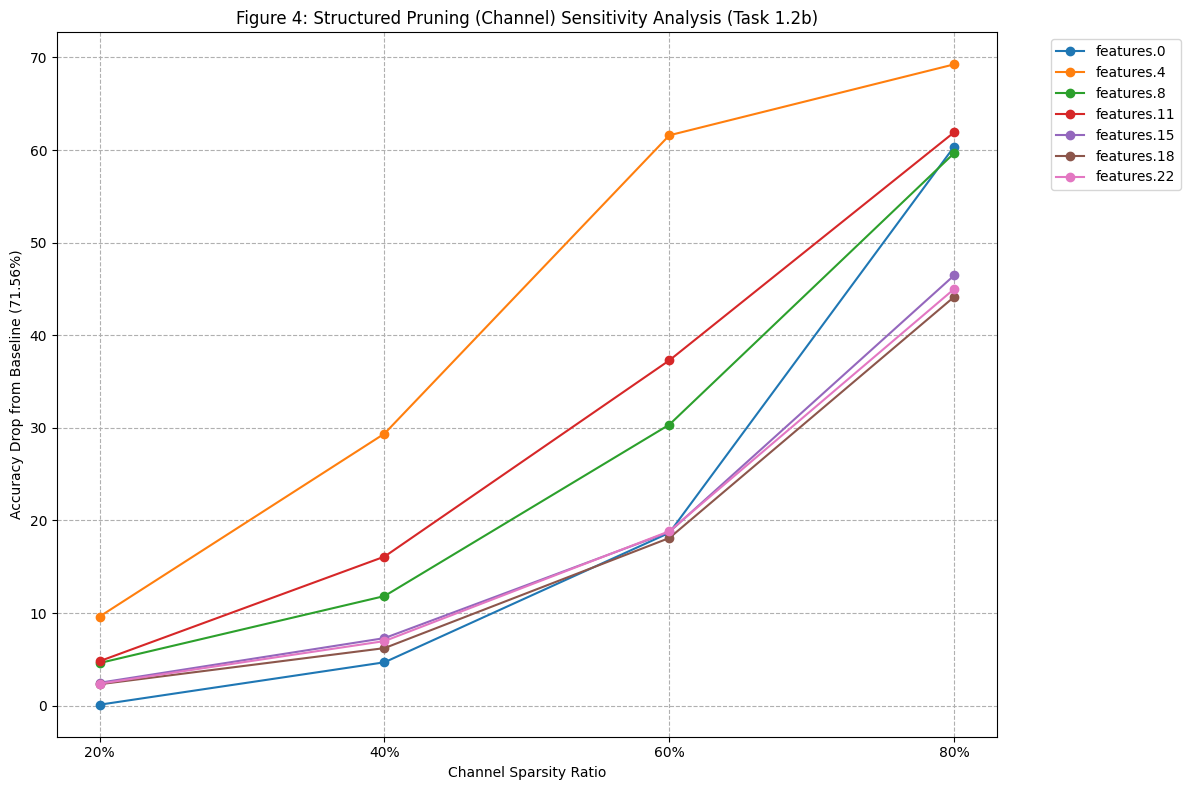

In [73]:
# --- Plot the results ---
baseline_acc = 71.56 # From our baseline
sparsity_ratios_to_plot = [0.2, 0.4, 0.6, 0.8]

plt.figure(figsize=(12, 8))
for layer_name in structured_layer_names:
    accuracies = structured_sensitivity_results[layer_name]
    accuracy_drops = [baseline_acc - acc for acc in accuracies]
    plt.plot(sparsity_ratios_to_plot, accuracy_drops, marker='o', label=layer_name)

plt.title('Figure 4: Structured Pruning (Channel) Sensitivity Analysis (Task 1.2b)')
plt.xlabel('Channel Sparsity Ratio')
plt.ylabel(f'Accuracy Drop from Baseline ({baseline_acc}%)')
plt.xticks(sparsity_ratios_to_plot, ['20%', '40%', '60%', '80%'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--')
plt.tight_layout()
plt.show()

In [75]:
# --- 4a. Count Parameters for All Layers (Corrected) ---

# Load the baseline model to count parameters
model = VGG('VGG11')
model.load_state_dict(torch.load(MODEL_PATH))
model.to(device)

layer_params = {}
total_params = 0

print("--- Parameter Counts per Layer ---")
# Count parameters in Convolutional + BatchNorm layers
# We iterate through the list of child modules in model.features
features_children = list(model.features.named_children())
i = 0
while i < len(features_children):
    name, module = features_children[i]
    if isinstance(module, nn.Conv2d):
        conv_params = module.weight.numel()
        if module.bias is not None:
            conv_params += module.bias.numel()
        
        # Find the next BN layer
        bn_params = 0
        if i + 1 < len(features_children) and isinstance(features_children[i+1][1], nn.BatchNorm2d):
            bn_module = features_children[i+1][1] # Get the module itself
            bn_params = bn_module.weight.numel() + bn_module.bias.numel() + \
                        bn_module.running_mean.numel() + bn_module.running_var.numel()
            i += 1 # Skip the BN layer in the next iteration
            
        layer_name = f"features.{name}"
        layer_params[layer_name] = conv_params + bn_params
        total_params += (conv_params + bn_params)
        print(f"Layer {layer_name} (Conv+BN): {conv_params + bn_params:,} parameters")
        
    i += 1

# Count parameters in Linear (Classifier) layers
for name, module in model.classifier.named_children():
    if isinstance(module, nn.Linear):
        num_params = module.weight.numel() + module.bias.numel()
        layer_name = f"classifier.{name}"
        layer_params[layer_name] = num_params
        total_params += num_params
        print(f"Layer {layer_name} (Linear): {num_params:,} parameters")

print("-----------------------------------")
print(f"Total Prunable Parameters: {total_params:,}")

--- Parameter Counts per Layer ---
Layer features.0 (Conv+BN): 2,048 parameters
Layer features.4 (Conv+BN): 74,368 parameters
Layer features.8 (Conv+BN): 296,192 parameters
Layer features.11 (Conv+BN): 591,104 parameters
Layer features.15 (Conv+BN): 1,182,208 parameters
Layer features.18 (Conv+BN): 2,361,856 parameters
Layer features.22 (Conv+BN): 2,361,856 parameters
Layer features.25 (Conv+BN): 2,361,856 parameters
Layer classifier.0 (Linear): 2,101,248 parameters
Layer classifier.3 (Linear): 16,781,312 parameters
Layer classifier.6 (Linear): 409,700 parameters
-----------------------------------
Total Prunable Parameters: 28,523,748


In [77]:
# --- 4b. Define Sparsity Ratios & Generate Table 2 (Corrected) ---
# (This assumes 'layer_params' and 'total_params' from 4a are in memory)

# 1. Targets for CONV layers (Structured/Channel Pruning)
#    (Based on Figure 4: Conservative on sensitive layers)
channel_targets = {
    'features.0': 0.10,  # Sensitive
    'features.4': 0.10,  # EXTREMELY Sensitive
    'features.8': 0.10,  # Very Sensitive
    'features.11': 0.10, # Very Sensitive
    'features.15': 0.20, # Moderate
    'features.18': 0.20, # Moderate
    'features.22': 0.30, # Less Sensitive
}
# We must convert this from a dict to the simple list our `channel_prune` function expects
channel_ratio_list = [
    channel_targets['features.0'], channel_targets['features.4'],
    channel_targets['features.8'], channel_targets['features.11'],
    channel_targets['features.15'], channel_targets['features.18'],
    channel_targets['features.22']
]

# 2. Targets for LINEAR layers (Unstructured/Weight Pruning)
#    (Aggressive, tuned to hit ~70% total parameter budget)
unstructured_targets = {
    'classifier.0': 0.95, 
    'classifier.3': 0.97, # This is the largest layer
    'classifier.6': 0.10, # Final layer
}

# --- 4c. Calculate Overall Sparsity & Generate Table 2 ---
print("--- Table 2: Final Sparsity Ratios (Structured 70% Model) ---")
print(f"| {'Layer Name':<15} | {'Pruning Type':<15} | {'Chosen Sparsity':<17} |")
print(f"|{'-'*17}|{'-'*17}|{'-'*19}|")

total_pruned_params = 0

# Calculate pruned params from Conv layers (simple approximation)
for name, ratio in channel_targets.items():
    print(f"| {name:<15} | {'Channel':<15} | {ratio*100:<17.0f}% |")
    if name in layer_params:
        total_pruned_params += layer_params[name] * ratio

# Add the last (unpruned) Conv layer to the table
print(f"| {'features.25':<15} | {'Channel':<15} | {0.0:<17.0f}% |")
# No params pruned from this block

# Calculate pruned params from Linear layers
for name, ratio in unstructured_targets.items():
    print(f"| {name:<15} | {'Weight':<15} | {ratio*100:<17.0f}% |")
    if name in layer_params:
        total_pruned_params += layer_params[name] * ratio

print("-----------------------------------------------------")
structured_sparsity = total_pruned_params / total_params
print(f"Target Overall Parameter Sparsity: {structured_sparsity * 100:.2f}%")

--- Table 2: Final Sparsity Ratios (Structured 70% Model) ---
| Layer Name      | Pruning Type    | Chosen Sparsity   |
|-----------------|-----------------|-------------------|
| features.0      | Channel         | 10               % |
| features.4      | Channel         | 10               % |
| features.8      | Channel         | 10               % |
| features.11     | Channel         | 10               % |
| features.15     | Channel         | 20               % |
| features.18     | Channel         | 20               % |
| features.22     | Channel         | 30               % |
| features.25     | Channel         | 0                % |
| classifier.0    | Weight          | 95               % |
| classifier.3    | Weight          | 97               % |
| classifier.6    | Weight          | 10               % |
-----------------------------------------------------
Target Overall Parameter Sparsity: 69.52%


In [78]:
# --- Helper functions for Unstructured Pruning (from Phase 1) ---

def create_unstructured_mask(layer, sparsity_ratio):
    """Creates a magnitude-based mask for individual weights."""
    weights = layer.weight.data
    abs_weights = torch.abs(weights)
    
    num_weights = weights.numel()
    num_to_prune = int(num_weights * sparsity_ratio)
    
    if num_to_prune == 0:
        return torch.ones_like(weights)
    
    # k must be at least 1 for kthvalue
    threshold = torch.kthvalue(abs_weights.view(-1), max(1, num_to_prune)).values
    mask = (abs_weights > threshold).float()
    return mask

def apply_pruning_mask(layer, mask):
    """Applies a mask to a layer's weights in-place."""
    with torch.no_grad():
        layer.weight.data.mul_(mask)
        if layer.bias is not None:
            # Also prune bias, though it has little impact on size
            layer.bias.data.mul_(mask.mean(dim=1)) # A simple way to prune bias

print("Unstructured pruning helper functions defined.")

Unstructured pruning helper functions defined.


In [79]:
# --- 5a. Define the Hybrid Pruning Plan ---
# (Based on your verified 69.52% plan)
channel_ratio_list = [0.10, 0.10, 0.10, 0.10, 0.20, 0.20, 0.30]

unstructured_targets = {
    'classifier.0': 0.95, 
    'classifier.3': 0.97, 
    'classifier.6': 0.10,
}

# --- 5b. Load and Sort the Baseline Model ---
print("--- Starting Task 1.2c: Creating 70% Hybrid Pruned Model ---")
baseline_model = VGG('VGG11')
baseline_model.load_state_dict(torch.load(MODEL_PATH))
baseline_model.to(device)
baseline_model.eval()

print("1. Sorting model channels by magnitude...")
sorted_model = apply_channel_sorting(baseline_model)
print("Model sorted.")

# --- 5c. Apply Structured (Channel) Pruning ---
print("2. Applying structured (channel) pruning to features...")
# This creates a new, physically smaller model
structured_pruned_model = channel_prune(sorted_model, channel_ratio_list)
print("Channel pruning complete.")

# --- 5d. Apply Unstructured (Weight) Pruning ---
print("3. Applying unstructured (weight) pruning to classifier...")
# We apply masks to the *new, smaller* structured_pruned_model
for name, module in structured_pruned_model.classifier.named_children():
    if isinstance(module, nn.Linear):
        layer_name = f"classifier.{name}"
        if layer_name in unstructured_targets:
            ratio = unstructured_targets[layer_name]
            mask = create_unstructured_mask(module, ratio)
            apply_pruning_mask(module, mask)
            print(f"Applied {ratio*100:.0f}% weight sparsity to layer {layer_name}")
print("Weight pruning complete.")

# --- 5e. Save and Test the Final Model ---
MODEL_PATH_STRUCTURED = 'structured_pruned_70.pth'
torch.save(structured_pruned_model.state_dict(), MODEL_PATH_STRUCTURED)
print(f"\nSaved final hybrid model to {MODEL_PATH_STRUCTURED}")

criterion = nn.CrossEntropyLoss()
baseline_acc = 71.56 # From Phase 0
final_acc_structured = test_model(structured_pruned_model, testloader, criterion, epoch=-1)
print("-----------------------------------")
print(f"Baseline Accuracy: {baseline_acc:.2f}%")
print(f"Final Structured (Hybrid) Pruned Accuracy: {final_acc_structured:.2f}%")
print(f"Accuracy Drop: {baseline_acc - final_acc_structured:.2f}%")

# Clean up memory
del baseline_model
del sorted_model
del structured_pruned_model
torch.cuda.empty_cache()

--- Starting Task 1.2c: Creating 70% Hybrid Pruned Model ---
1. Sorting model channels by magnitude...
Model sorted.
2. Applying structured (channel) pruning to features...
Channel pruning complete.
3. Applying unstructured (weight) pruning to classifier...
Applied 95% weight sparsity to layer classifier.0
Applied 97% weight sparsity to layer classifier.3
Applied 10% weight sparsity to layer classifier.6
Weight pruning complete.

Saved final hybrid model to structured_pruned_70.pth


Epoch 0 [Test]: 100%|██████████| 100/100 [00:02<00:00, 46.49it/s, acc=48.5, loss=3.68]

-----------------------------------
Baseline Accuracy: 71.56%
Final Structured (Hybrid) Pruned Accuracy: 48.54%
Accuracy Drop: 23.02%


--- Plotting Final Distributions (Task 1.2a) ---

--- Plotting 'Figure 3a: Original Model Weight Distribution' ---
  Total weights counted: 28,501,696
  Zero-value weights: 0 (0.00%)
  Non-zero weights: 28,501,696



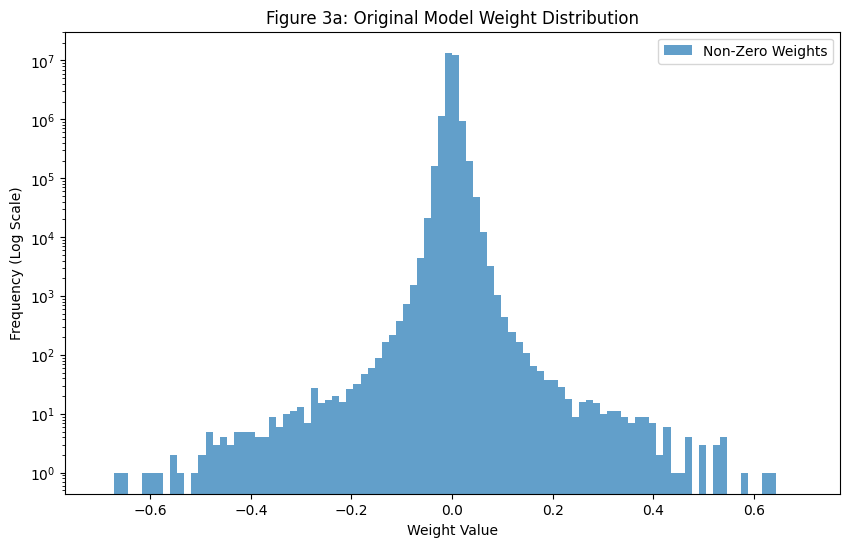


Reconstructing pruned model architecture for plotting...

--- Plotting 'Figure 3b: Structured Pruned (70%) Model Weight Distribution' ---
  Total weights counted: 25,391,998
  Zero-value weights: 18,307,153 (72.10%)
  Non-zero weights: 7,084,845



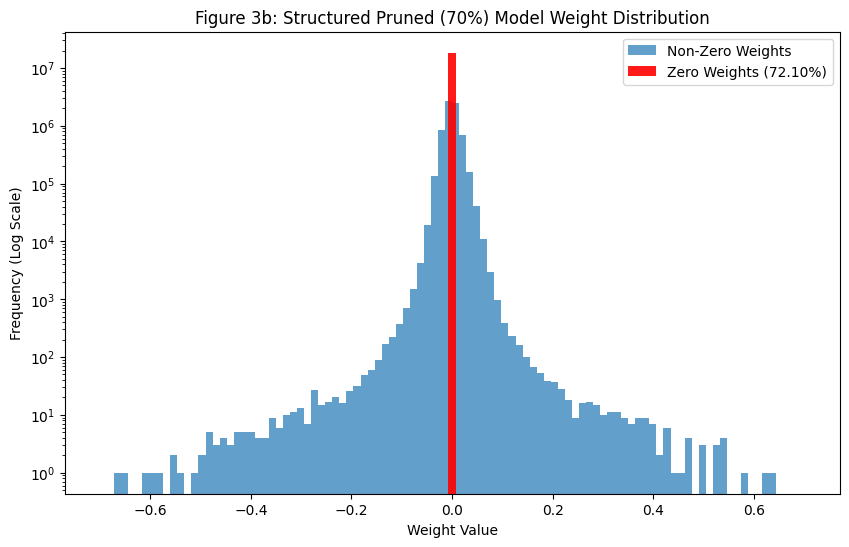

In [81]:
print("--- Plotting Final Distributions (Task 1.2a) ---")

# 1. Load and plot the baseline model (Figure 3a)
baseline_model = VGG('VGG11')
baseline_model.load_state_dict(torch.load(MODEL_PATH))
baseline_model.to(device) # <--- ADD THIS LINE TO MOVE MODEL TO GPU
plot_weight_distribution(baseline_model, title="Figure 3a: Original Model Weight Distribution")

# 2. Load and plot the structured pruned model (Figure 3b)
print("\nReconstructing pruned model architecture for plotting...")
# 'baseline_model' is now on the correct device
sorted_model = apply_channel_sorting(baseline_model) # Sort
structured_pruned_model_for_plot = channel_prune(sorted_model, channel_ratio_list) # Rebuild
# Now load the weights we saved (which include the unstructured masks)
structured_pruned_model_for_plot.load_state_dict(torch.load(MODEL_PATH_STRUCTURED))

plot_weight_distribution(structured_pruned_model_for_plot, title="Figure 3b: Structured Pruned (70%) Model Weight Distribution")

# Clean up
del baseline_model
del sorted_model
del structured_pruned_model_for_plot

## Comparision and Analysis

In [82]:
print("--- Task 1.3c: Structured Model Storage & Inference Analysis ---")

# --- 7a. Reconstruct the Pruned Model Architecture ---
# We must build the small model first, *then* load its weights
baseline_model = VGG('VGG11').to(device) # Need this for sorting
sorted_model = apply_channel_sorting(baseline_model)

# Define the channel ratios we used
channel_ratio_list = [0.10, 0.10, 0.10, 0.10, 0.20, 0.20, 0.30]

# Build the new, physically smaller model
structured_model_for_speed_test = channel_prune(sorted_model, channel_ratio_list)

# Now, load the saved weights (which include the unstructured masks on the linear layers)
MODEL_PATH_STRUCTURED = 'structured_pruned_70.pth'
structured_model_for_speed_test.load_state_dict(torch.load(MODEL_PATH_STRUCTURED))
structured_model_for_speed_test.to(device)
structured_model_for_speed_test.eval()

# --- 7b. Get Metrics ---
structured_size_mb = get_model_size(MODEL_PATH_STRUCTURED)
structured_mean_ms, structured_std_ms = get_inference_time(structured_model_for_speed_test, testloader, device)

# --- 7c. Print Final Comparison Table (Task 1.3) ---
# (Fetching all our previous results)
baseline_size_mb = 108.83
baseline_mean_ms = 1.8051
unstructured_size_mb = 108.83
unstructured_mean_ms = 1.7730

print("\n--- Final Model Comparison Table (Storage & Speed) ---")
print(f"| {'Metric':<25} | {'Baseline':<15} | {'Unstructured (75%)':<20} | {'Structured (75%)':<20} |")
print(f"|{'-'*27}|{'-'*17}|{'-'*22}|{'-'*22}|")
print(f"| {'File Size (MB)':<25} | {baseline_size_mb:<15.2f} | {unstructured_size_mb:<20.2f} | {structured_size_mb:<20.2f} |")
print(f"| {'Avg. Inference Time (ms)':<25} | {baseline_mean_ms:<15.4f} | {unstructured_mean_ms:<20.4f} | {structured_mean_ms:<20.4f} |")

# Clean up
del baseline_model
del sorted_model
del structured_model_for_speed_test

--- Task 1.3c: Structured Model Storage & Inference Analysis ---

--- Final Model Comparison Table (Storage & Speed) ---
| Metric                    | Baseline        | Unstructured (75%)   | Structured (75%)     |
|---------------------------|-----------------|----------------------|----------------------|
| File Size (MB)            | 108.83          | 108.83               | 96.96                |
| Avg. Inference Time (ms)  | 1.8051          | 1.7730               | 1.5839               |


In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 43.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.5 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00:

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.utils import make_grid
from grad_cam.grad_cam import GradCAM
from grad_cam.utils.model_targets import ClassifierOutputTarget
from grad_cam.utils.image import show_cam_on_image, denormalize_image

print("--- Task 1.3a: Grad-CAM Comparison ---")

# --- 1. Load All Three Models ---

# Load Baseline Model
print("Loading Baseline Model...")
baseline_model = VGG('VGG11')
baseline_model.load_state_dict(torch.load(MODEL_PATH))
baseline_model.to(device).eval()

# Load Unstructured Pruned Model
print("Loading Unstructured (75%) Model...")
unstructured_model = VGG('VGG11')
unstructured_model.load_state_dict(torch.load(MODEL_PATH_UNSTRUCTURED))
unstructured_model.to(device).eval()

# Load Structured (Hybrid) Pruned Model
print("Reconstructing and Loading Structured (75%) Model...")
# We must build the small model first, *then* load its weights
sorted_baseline_model = apply_channel_sorting(baseline_model)
channel_ratio_list = [0.10, 0.10, 0.10, 0.10, 0.20, 0.20, 0.30]
structured_model = channel_prune(sorted_baseline_model, channel_ratio_list)
# Now, load the saved weights (which include the unstructured masks on the linear layers)
structured_model.load_state_dict(torch.load(MODEL_PATH_STRUCTURED))
structured_model.to(device).eval()
print("All models loaded.")

# --- 2. Define Target Layers ---
# We'll visualize the last convolutional layer of each model
target_layer_baseline = [baseline_model.features[-2]] # -2 is the last Conv2d
target_layer_unstructured = [unstructured_model.features[-2]]
# The structured model's last conv layer is still at index -2
target_layer_structured = [structured_model.features[-2]] 

# --- 3. Set up Grad-CAM ---
cam_baseline = GradCAM(model=baseline_model, target_layers=target_layer_baseline, use_cuda=torch.cuda.is_available())
cam_unstructured = GradCAM(model=unstructured_model, target_layers=target_layer_unstructured, use_cuda=torch.cuda.is_available())
cam_structured = GradCAM(model=structured_model, target_layers=target_layer_structured, use_cuda=torch.cuda.is_available())

# --- 4. Get a batch of images to test ---
# (Assumes 'testloader' is in memory)
data_iter = iter(testloader)
images, labels = next(data_iter)
images = images.to(device)

# We'll visualize the first 4 images from the batch
input_tensor = images[0:4]
targets = [ClassifierOutputTarget(label) for label in labels[0:4]]

# --- 5. Generate Visualizations ---
print("Generating heatmaps...")
grayscale_cam_baseline = cam_baseline(input_tensor=input_tensor, targets=targets)
grayscale_cam_unstructured = cam_unstructured(input_tensor=input_tensor, targets=targets)
grayscale_cam_structured = cam_structured(input_tensor=input_tensor, targets=targets)

# --- 6. Plot the comparison ---
mean_cifar = [0.5071, 0.4867, 0.4408]
std_cifar = [0.2675, 0.2565, 0.2761]

# Denormalize images for plotting
rgb_images = [denormalize_image(img.cpu().numpy().transpose((1, 2, 0)), mean_cifar, std_cifar) for img in input_tensor]

viz_baseline_list = []
viz_unstructured_list = []
viz_structured_list = []

for i in range(len(rgb_images)):
    viz_baseline = show_cam_on_image(rgb_images[i], grayscale_cam_baseline[i, :], use_rgb=True)
    viz_unstructured = show_cam_on_image(rgb_images[i], grayscale_cam_unstructured[i, :], use_rgb=True)
    viz_structured = show_cam_on_image(rgb_images[i], grayscale_cam_structured[i, :], use_rgb=True)
    
    viz_baseline_list.append(torch.tensor(viz_baseline).permute(2, 0, 1))
    viz_unstructured_list.append(torch.tensor(viz_unstructured).permute(2, 0, 1))
    viz_structured_list.append(torch.tensor(viz_structured).permute(2, 0, 1))

# Create grid
grid_baseline = make_grid(viz_baseline_list, nrow=4, padding=4, pad_value=1)
grid_unstructured = make_grid(viz_unstructured_list, nrow=4, padding=4, pad_value=1)
grid_structured = make_grid(viz_structured_list, nrow=4, padding=4, pad_value=1)

# Stack them vertically
grid_combined = torch.cat((grid_baseline, grid_unstructured, grid_structured), dim=1)

# Plot
print("Plotting comparison grid...")
plt.figure(figsize=(15, 12))
plt.imshow(grid_combined.permute(1, 2, 0))
plt.title("Figure (Task 1.3a): Grad-CAM Analysis\n(Top: Baseline, Middle: Unstructured, Bottom: Structured)", fontsize=16)
plt.axis('off')
plt.show()

# Clean up memory
del baseline_model
del unstructured_model
del sorted_baseline_model
del structured_model

ModuleNotFoundError: No module named 'grad_cam'